Here we want to explore the 10X "1k" data to see if we can 'find the ambient barcodes'

In [4]:
import pyximport
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance
import umi_tools.umi_methods as umi_methods
import umi_tools.Utilities as U
import collections
import pandas as pd
import numpy as np
import pysam
import regex
import glob
import CGAT.Fastq as Fastq
import CGAT.IOTools as IOTools

%load_ext rpy2.ipython
%matplotlib inline  

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
fastq_infiles = glob.glob("../run/raw/10X_1k_fastqs/*R1*.fastq.gz")
fastq_infiles2 = glob.glob("../run/raw/10X_1k_fastqs/*R2*.fastq.gz")
print(len(fastq_infiles))
print(len(fastq_infiles2))


8
8


In [7]:
# extract UMI, cell and sequence qualities and derive cell and umi counts from fastqs
def phredToInt(phreds):
    return(list(map(lambda x: ord(x)-33, phreds)))

cell_umi_counts = collections.defaultdict(set)
cell_counts = collections.Counter()

qualities = collections.defaultdict(
    lambda: collections.defaultdict(collections.Counter))

ReadExtractor = umi_methods.ExtractFilterAndUpdate(
    method="string", pattern="CCCCCCCCCCCCCCCCNNNNNNNNNN", extract_cell=True)

n = 0
for fastq_infile, fastq_infile2 in zip(fastq_infiles, fastq_infiles2):
    read1s = umi_methods.fastqIterate(U.openFile(fastq_infile))
    read2s = umi_methods.fastqIterate(U.openFile(fastq_infile2))
    
    print(fastq_infile, fastq_infile2)
    
    sample_n = 0
    
    for read1 in read1s:
        read2 = next(read2s)
        
        sample_n += 1
        cell, umi, umi_quals, new_seq, new_quals, new_seq2, new_quals2 = ReadExtractor.getBarcodes(read1, None)

        cell_umi_counts[cell].add(umi)
        cell_counts[cell] += 1

        cell_quals = read1.quals[:16] # extractor doesn't extract the cell quals. grrrr...
        qualities[cell]['read'].update(phredToInt(read2.quals))
        qualities[cell]['cell'].update(phredToInt(cell_quals))
        qualities[cell]['umi'].update(phredToInt(umi_quals))

        if sample_n % 1000000 == 0:
            print("processed %iM reads" % (float(sample_n)/1000000))

        if sample_n >= 5000000:
            break
    
    n += sample_n
    print("processed %i reads, %i total" % (sample_n. n))
    
    if n > 50000000:
        break

    

../run/raw/10X_1k_fastqs/hgmm_1k_S1_L001_R1_001.fastq.gz ../run/raw/10X_1k_fastqs/hgmm_1k_S1_L001_R2_001.fastq.gz
processed 1M reads
processed 2M reads
processed 3M reads
processed 4M reads
processed 5M reads
processed 0 reads, 5000001 total
../run/raw/10X_1k_fastqs/hgmm_1k_S1_L002_R1_001.fastq.gz ../run/raw/10X_1k_fastqs/hgmm_1k_S1_L002_R2_001.fastq.gz
processed 1M reads
processed 2M reads
processed 3M reads
processed 4M reads
processed 5M reads
processed 5000001 reads, 5000001 total
../run/raw/10X_1k_fastqs/hgmm_1k_S1_L003_R1_001.fastq.gz ../run/raw/10X_1k_fastqs/hgmm_1k_S1_L003_R2_001.fastq.gz
processed 1M reads
processed 2M reads
processed 3M reads
processed 4M reads
processed 5M reads
processed 10000002 reads, 5000001 total
../run/raw/10X_1k_fastqs/hgmm_1k_S1_L004_R1_001.fastq.gz ../run/raw/10X_1k_fastqs/hgmm_1k_S1_L004_R2_001.fastq.gz
processed 1M reads
processed 2M reads
processed 3M reads
processed 4M reads
processed 5M reads
processed 15000003 reads, 5000001 total
../run/raw/1

KeyboardInterrupt: 

In [8]:
def getCounterMean(counter):
    sum_of_numbers = sum([number*count for number, count in counter.most_common()])
    count = sum(count for n, count in counter.most_common())
    mean = sum_of_numbers / count
    return mean 

final_qualities = collections.defaultdict(lambda: collections.defaultdict(float))

for cell in qualities:
    try:
        final_qualities[cell]['read'] = getCounterMean(qualities[cell]['read'])
        final_qualities[cell]['cell'] = getCounterMean(qualities[cell]['cell'])
        final_qualities[cell]['umi'] = getCounterMean(qualities[cell]['umi'])
    except:
        print(cell)
        print(qualities['cell'])

In [9]:
rows = []
n = 0
for cell in cell_umi_counts:
    
    row = (cell, cell_counts[cell], len(cell_umi_counts[cell]),
           1-(len(cell_umi_counts[cell])/cell_counts[cell]))
    
    rows.append(row)

#print(cell_umi_counts)

In [10]:
duplication_df = pd.DataFrame.from_records(
    rows, columns=["cell", "count", "unique_umi_count", "dup._rate"])
print(duplication_df.head())
print(duplication_df.shape)
duplication_df = duplication_df[duplication_df['count']>10]
print(duplication_df.shape)

               cell  count  unique_umi_count  dup._rate
0  ACGATTGTCTCCTCAT      1                 1   0.000000
1  TTTATGCGTAGGGACT      1                 1   0.000000
2  TACCTATGTTCCGGCA      1                 1   0.000000
3  GGCAATTGTTCCAACA     26                21   0.192308
4  TGCGTCGTCGCCTTGT      1                 1   0.000000
(519513, 4)
(95517, 4)


In [11]:
duplication_df['read_qual'] = [final_qualities[cell]['read'] for cell in duplication_df['cell']]
duplication_df['umi_qual'] = [final_qualities[cell]['umi'] for cell in duplication_df['cell']]
duplication_df['cell_qual'] = [final_qualities[cell]['cell'] for cell in duplication_df['cell']]

In [12]:
%%R -i duplication_df

library(ggplot2)
library(Hmisc)

print(head(duplication_df))


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Formula

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-linux-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘Hmisc’


  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2-2.8.5-py3.5-li

               cell count unique_umi_count  dup._rate read_qual umi_qual
3  GGCAATTGTTCCAACA    26               21 0.19230769  35.68485 39.34615
12 GCTCTGTTCCTACAGA    32               27 0.15625000  34.24904 40.15625
16 CGCGGTAGTCGCGGTT    24               22 0.08333333  34.63818 40.02917
18 GCAATCAAGGTGATTA    20               15 0.25000000  35.80204 40.20500
20 TCGGGCGTCTGCCAGT    15               13 0.13333333  34.80544 40.97333
26 GGACAGAGTCTGGAGA    46               36 0.21739130  34.79303 40.41087
   cell_qual
3   38.12500
12  37.84961
16  38.41667
18  37.56875
20  39.03333
26  38.32065


In [13]:
%%R
my_theme <- theme_bw() + theme(text=element_text(size=20), aspect.ratio=1)


[1] 4.506762


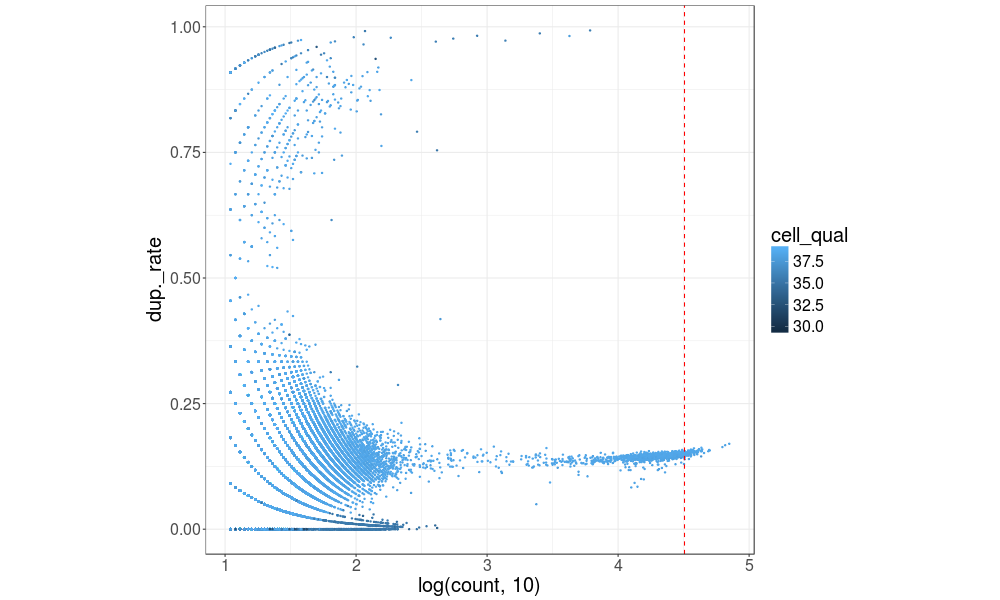

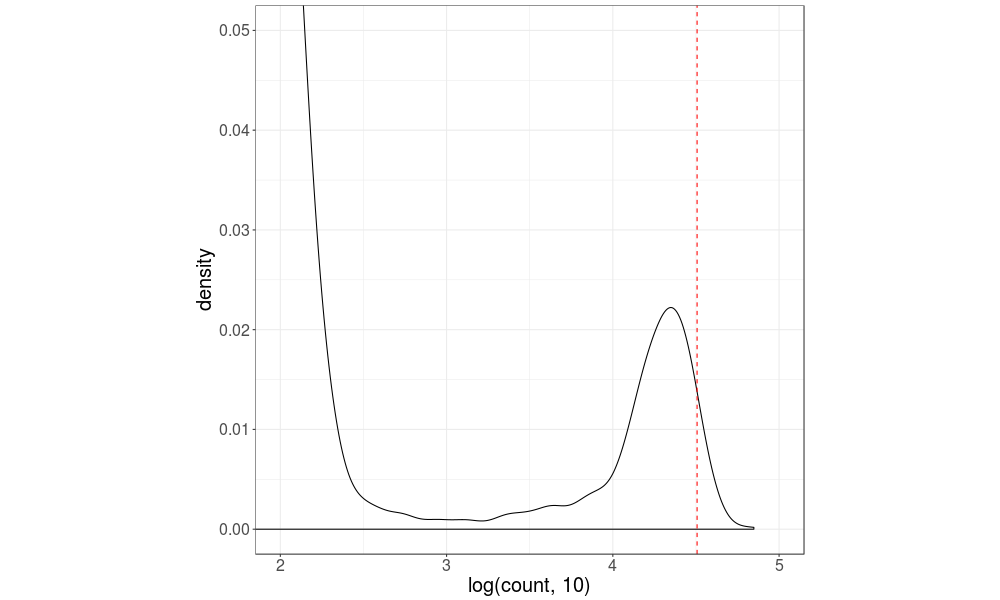

In [14]:
%%R -w 1000 -h 600
threshold = duplication_df[order(-duplication_df$count), "count"][100]
threshold_umi = duplication_df[order(-duplication_df$unique_umi_count), "unique_umi_count"][100]
print(log(threshold, 10))

p <- ggplot(duplication_df, aes(log(count,10), dup._rate, colour=cell_qual)) +
geom_point(size=0.5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2)

print(p) 

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density(adjust = 5) + my_theme  +
geom_vline(xintercept=log(threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(2,5), ylim=c(0,0.05))

print(p) 



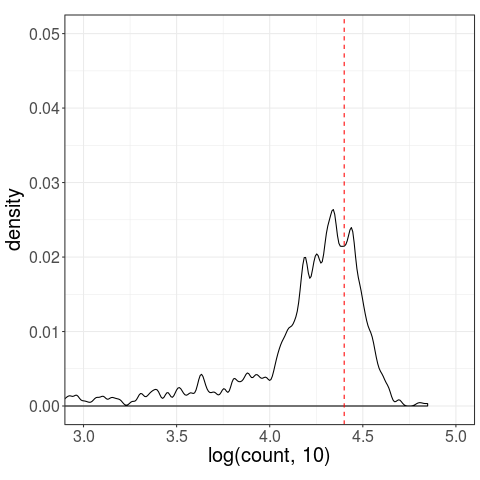

In [15]:
%%R
manual_threshold = 10^4.4
duplication_df$knee <- duplication_df$count > manual_threshold

p <- ggplot(duplication_df, aes(log(count,10))) + geom_density() + my_theme  +
geom_vline(xintercept=log(manual_threshold,10), colour="red", linetype=2) +
coord_cartesian(xlim = c(3,5), ylim=c(0,0.05))

print(p) 


                   cell count unique_umi_count dup._rate read_qual umi_qual
84919  GTTAAGCTCAACTCTT 70520            58534 0.1699660  35.57499 40.30944
98568  GTGCTTCTCGGGAGTA 65617            54650 0.1671366  34.93514 40.22875
15906  ACGAGGAGTAGGGACT 62483            52274 0.1633884  35.36755 40.19298
225492 GACTAACAGGCGCTCT 50018            42185 0.1566036  35.49078 40.18302
241775 GGCAATTAGGAATCGC 49545            41730 0.1577354  35.46744 40.19966
267248 CGGGTCATCGGCGCTA 48837            41261 0.1551283  34.86502 40.09269
       cell_qual knee x    cum
84919   38.35096 TRUE 1  70520
98568   38.19960 TRUE 2 136137
15906   38.23386 TRUE 3 198620
225492  38.36386 TRUE 4 248638
241775  38.39746 TRUE 5 298183
267248  38.17506 TRUE 6 347020
                   cell count unique_umi_count  dup._rate read_qual umi_qual
519088 GGACATTAGGATCGCA    11               10 0.09090909  35.73469 40.28182
       cell_qual  knee     x      cum
519088  38.45455 FALSE 95517 24335650
[1] 9441084


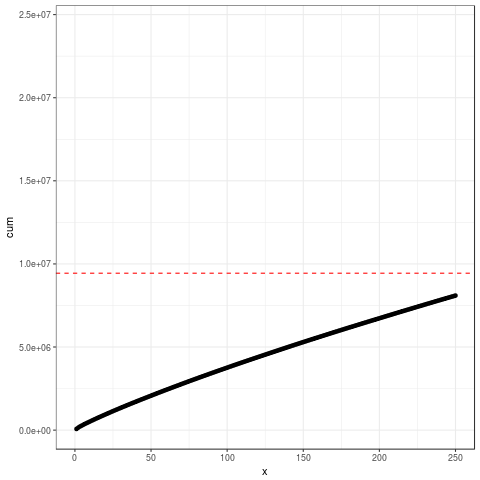

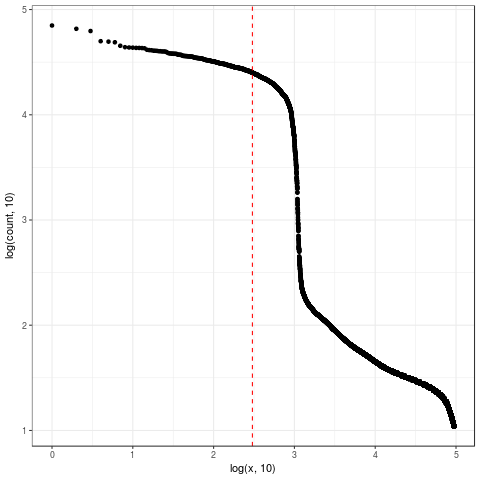

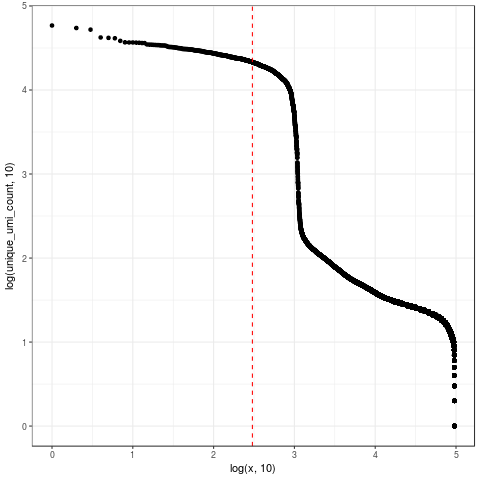

In [16]:
%%R
tmp_df <- duplication_df[order(-duplication_df$count),]
tmp_df$x <- seq(1, length(tmp_df[,1]))
tmp_df$cum <- cumsum(tmp_df$count)

tmp_df2 <- duplication_df[order(-duplication_df$unique_umi_count),]
tmp_df2$x <- seq(1, length(tmp_df2[,1]))
tmp_df2$cum <- cumsum(tmp_df2$unique_umi_count)

print(head(tmp_df))

print(tmp_df[tmp_df$x==length(tmp_df$count>manual_threshold),])

threshold_y_cum = sum(tmp_df[tmp_df$knee==TRUE, "count"])
print(threshold_y_cum)
threshold_x_cum = sum(tmp_df$knee==TRUE)

p <- ggplot(tmp_df, aes(x, cum)) + geom_point() + theme_bw() + xlim(0, 250) +
geom_hline(yintercept=threshold_y_cum, linetype=2, colour="red") +
geom_vline(xintercept=threshold_x_cum, linetype=2, colour="red")
print(p)


p <- ggplot(tmp_df, aes(log(x,10), log(count,10))) + geom_point() + theme_bw() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)

p <- ggplot(tmp_df2, aes(log(x,10), log(unique_umi_count,10))) + geom_point() + theme_bw()  +
geom_vline(xintercept=log(threshold_x_cum,10), linetype=2, colour="red")
print(p)
